In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.models import TESTVAE
 
from src.common.helperfunctions import *
from src.common.accuracy_XGboost import *


import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
label_col = []
feature_cols = []
label_col = [i for i in df.columns if 'Class' in i]
feature_cols = [i for i in df.columns if i not in label_col]

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [5]:
mxs = MinMaxScaler()
train.iloc[:,:] = mxs.fit_transform(train.iloc[:,:].values)
test.iloc[:,:] = mxs.transform(test.iloc[:,:].values)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
train_Class = train[train.Class == 1]

In [7]:
# sc = StandardScaler()
# train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
# test_X.loc[:,'Amount'] = sc.transform(test_X.Amount.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test_X.drop('Time', axis=1, inplace=True)

In [8]:
label_col = []
feature_cols = []
label_col = [i for i in train.columns if 'Class' in i]
feature_cols = [i for i in train.columns if i not in label_col]

# Train GAN

In [9]:
train_Class.drop('Class', axis = 1,inplace=True)
# train_Class.drop('Time', axis = 1,inplace=True)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
train_Class.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,...,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,0.460459,0.882117,0.804668,0.789376,0.454106,0.745540,0.248580,0.232283,0.792952,0.453685,...,0.583807,0.573374,0.510644,0.664096,0.367891,0.579340,0.435710,0.242968,0.314856,0.004352
std,0.278781,0.110547,0.042736,0.130531,0.125469,0.035252,0.017741,0.041740,0.066827,0.103345,...,0.013042,0.056664,0.064164,0.024285,0.070422,0.046032,0.077310,0.032057,0.010831,0.009317
min,0.002350,0.439247,0.678603,0.327953,0.193714,0.616903,0.198611,0.000000,0.345109,0.000000,...,0.536310,0.193973,0.095452,0.379490,0.108959,0.309503,0.237611,0.063405,0.275190,0.000000
25%,0.238237,0.858256,0.780714,0.760412,0.359170,0.733984,0.237958,0.218303,0.783666,0.397028,...,0.578364,0.562816,0.485348,0.660343,0.322935,0.559571,0.384008,0.237973,0.310967,0.000039
50%,0.438192,0.920690,0.796274,0.822133,0.440937,0.756893,0.248623,0.247029,0.792052,0.469722,...,0.583163,0.570970,0.512663,0.664301,0.373181,0.583192,0.429032,0.247911,0.315899,0.000357
75%,0.727155,0.954272,0.816778,0.877708,0.533033,0.767393,0.258487,0.259373,0.804385,0.528544,...,0.588796,0.582366,0.538727,0.669426,0.423414,0.603487,0.491854,0.257430,0.320679,0.004049
max,0.985856,0.994520,1.000000,0.963103,0.788963,0.840408,0.328111,0.298443,1.000000,0.703144,...,0.698016,1.000000,0.897985,0.746612,0.529304,0.701859,0.873881,0.311934,0.349233,0.082747


In [11]:
dataloader = prepareDataset(train_Class, batch_size = 64, device = 'cpu', withLabel = False)

In [12]:
dataloader.dataset.features.size(1)

30

Starting Training Loop...
394 394
epoch: 0, Accuracy: 1.0


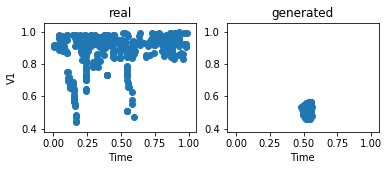

====> Epoch: 0 Average loss: 21.2039
====> Epoch: 1 Average loss: 21.0134
====> Epoch: 2 Average loss: 20.8509
====> Epoch: 3 Average loss: 20.6883
====> Epoch: 4 Average loss: 20.5050
====> Epoch: 5 Average loss: 20.3300
====> Epoch: 6 Average loss: 20.1177
====> Epoch: 7 Average loss: 19.9126
====> Epoch: 8 Average loss: 19.7072
====> Epoch: 9 Average loss: 19.5348
394 394
epoch: 10, Accuracy: 0.9873096446700508


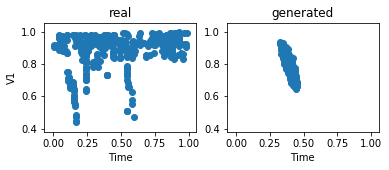

====> Epoch: 10 Average loss: 19.4161
====> Epoch: 11 Average loss: 19.3043
====> Epoch: 12 Average loss: 19.1728
====> Epoch: 13 Average loss: 19.1578
====> Epoch: 14 Average loss: 19.1251
====> Epoch: 15 Average loss: 18.9911
====> Epoch: 16 Average loss: 18.9710
====> Epoch: 17 Average loss: 18.9027
====> Epoch: 18 Average loss: 18.8542
====> Epoch: 19 Average loss: 18.8329
394 394
epoch: 20, Accuracy: 0.9847715736040609


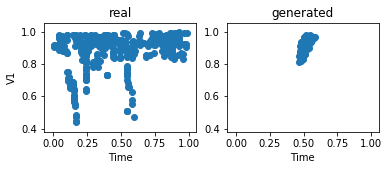

====> Epoch: 20 Average loss: 18.8538
====> Epoch: 21 Average loss: 18.8704
====> Epoch: 22 Average loss: 18.8643
====> Epoch: 23 Average loss: 18.8704
====> Epoch: 24 Average loss: 18.8903
====> Epoch: 25 Average loss: 18.9000
====> Epoch: 26 Average loss: 18.9159
====> Epoch: 27 Average loss: 18.9162
====> Epoch: 28 Average loss: 18.9140
====> Epoch: 29 Average loss: 18.9186
394 394
epoch: 30, Accuracy: 1.0


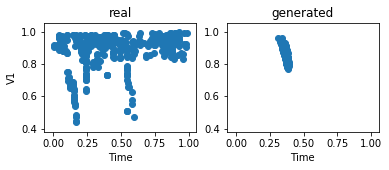

====> Epoch: 30 Average loss: 18.9101
====> Epoch: 31 Average loss: 18.9103
====> Epoch: 32 Average loss: 18.8751
====> Epoch: 33 Average loss: 18.8526
====> Epoch: 34 Average loss: 18.8332
====> Epoch: 35 Average loss: 18.8240
====> Epoch: 36 Average loss: 18.8071
====> Epoch: 37 Average loss: 18.7906
====> Epoch: 38 Average loss: 18.7980
====> Epoch: 39 Average loss: 18.7799
394 394
epoch: 40, Accuracy: 0.9771573604060914


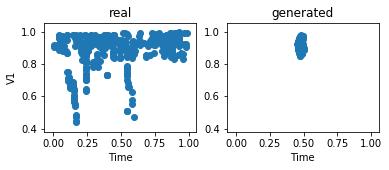

====> Epoch: 40 Average loss: 18.7826
====> Epoch: 41 Average loss: 18.7700
====> Epoch: 42 Average loss: 18.7527
====> Epoch: 43 Average loss: 18.7443
====> Epoch: 44 Average loss: 18.7278
====> Epoch: 45 Average loss: 18.7180
====> Epoch: 46 Average loss: 18.6702
====> Epoch: 47 Average loss: 18.6531
====> Epoch: 48 Average loss: 18.6375
====> Epoch: 49 Average loss: 18.6229
394 394
epoch: 50, Accuracy: 0.9949238578680203


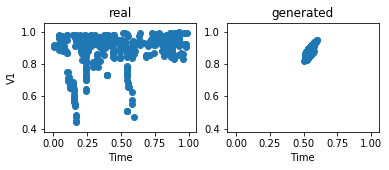

====> Epoch: 50 Average loss: 18.6043
====> Epoch: 51 Average loss: 18.5973
====> Epoch: 52 Average loss: 18.6000
====> Epoch: 53 Average loss: 18.5947
====> Epoch: 54 Average loss: 18.5941
====> Epoch: 55 Average loss: 18.5962
====> Epoch: 56 Average loss: 18.6093
====> Epoch: 57 Average loss: 18.6013
====> Epoch: 58 Average loss: 18.6093
====> Epoch: 59 Average loss: 18.6116
394 394
epoch: 60, Accuracy: 0.9974619289340102


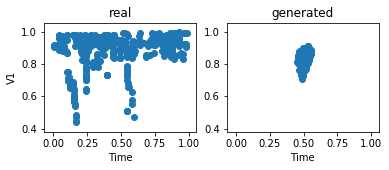

====> Epoch: 60 Average loss: 18.6083
====> Epoch: 61 Average loss: 18.6050
====> Epoch: 62 Average loss: 18.6042
====> Epoch: 63 Average loss: 18.5932
====> Epoch: 64 Average loss: 18.5927
====> Epoch: 65 Average loss: 18.5884
====> Epoch: 66 Average loss: 18.5769
====> Epoch: 67 Average loss: 18.5803
====> Epoch: 68 Average loss: 18.5689
====> Epoch: 69 Average loss: 18.5701
394 394
epoch: 70, Accuracy: 0.9898477157360406


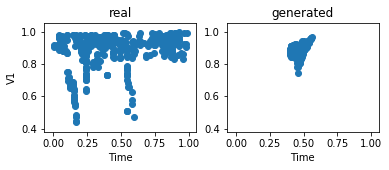

====> Epoch: 70 Average loss: 18.5758
====> Epoch: 71 Average loss: 18.5781
====> Epoch: 72 Average loss: 18.5751
====> Epoch: 73 Average loss: 18.5647
====> Epoch: 74 Average loss: 18.5764
====> Epoch: 75 Average loss: 18.5564
====> Epoch: 76 Average loss: 18.5648
====> Epoch: 77 Average loss: 18.5575
====> Epoch: 78 Average loss: 18.5472
====> Epoch: 79 Average loss: 18.5379
394 394
epoch: 80, Accuracy: 0.9873096446700508


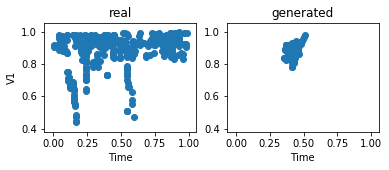

====> Epoch: 80 Average loss: 18.5277
====> Epoch: 81 Average loss: 18.5310
====> Epoch: 82 Average loss: 18.5300
====> Epoch: 83 Average loss: 18.5307
====> Epoch: 84 Average loss: 18.5317
====> Epoch: 85 Average loss: 18.5453
====> Epoch: 86 Average loss: 18.5331
====> Epoch: 87 Average loss: 18.5563
====> Epoch: 88 Average loss: 18.5695
====> Epoch: 89 Average loss: 18.5597
394 394
epoch: 90, Accuracy: 0.9923857868020305


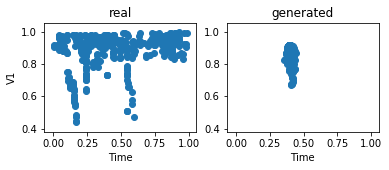

====> Epoch: 90 Average loss: 18.5843
====> Epoch: 91 Average loss: 18.5764
====> Epoch: 92 Average loss: 18.5906
====> Epoch: 93 Average loss: 18.5917
====> Epoch: 94 Average loss: 18.5980
====> Epoch: 95 Average loss: 18.6094
====> Epoch: 96 Average loss: 18.6019
====> Epoch: 97 Average loss: 18.6050
====> Epoch: 98 Average loss: 18.5902
====> Epoch: 99 Average loss: 18.5959
394 394
epoch: 100, Accuracy: 0.9898477157360406


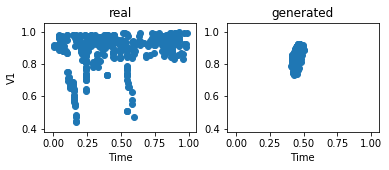

====> Epoch: 100 Average loss: 18.5886
====> Epoch: 101 Average loss: 18.5842
====> Epoch: 102 Average loss: 18.5722
====> Epoch: 103 Average loss: 18.5653
====> Epoch: 104 Average loss: 18.5664
====> Epoch: 105 Average loss: 18.5631
====> Epoch: 106 Average loss: 18.5576
====> Epoch: 107 Average loss: 18.5552
====> Epoch: 108 Average loss: 18.5506
====> Epoch: 109 Average loss: 18.5388
394 394
epoch: 110, Accuracy: 0.9898477157360406


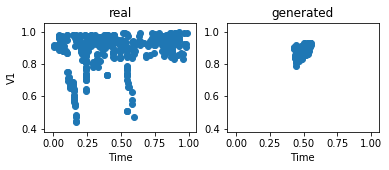

====> Epoch: 110 Average loss: 18.5312
====> Epoch: 111 Average loss: 18.5335
====> Epoch: 112 Average loss: 18.5320
====> Epoch: 113 Average loss: 18.5346
====> Epoch: 114 Average loss: 18.5182
====> Epoch: 115 Average loss: 18.5215
====> Epoch: 116 Average loss: 18.5251
====> Epoch: 117 Average loss: 18.5344
====> Epoch: 118 Average loss: 18.5211
====> Epoch: 119 Average loss: 18.5140
394 394
epoch: 120, Accuracy: 0.9923857868020305


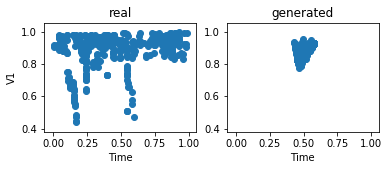

====> Epoch: 120 Average loss: 18.5135
====> Epoch: 121 Average loss: 18.5099
====> Epoch: 122 Average loss: 18.5059
====> Epoch: 123 Average loss: 18.5138
====> Epoch: 124 Average loss: 18.5242
====> Epoch: 125 Average loss: 18.5194
====> Epoch: 126 Average loss: 18.5253
====> Epoch: 127 Average loss: 18.5353
====> Epoch: 128 Average loss: 18.5380
====> Epoch: 129 Average loss: 18.5443
394 394
epoch: 130, Accuracy: 0.9898477157360406


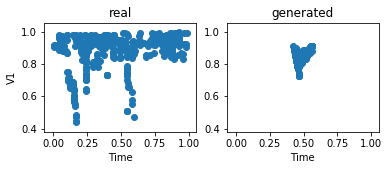

====> Epoch: 130 Average loss: 18.5494
====> Epoch: 131 Average loss: 18.5632
====> Epoch: 132 Average loss: 18.5576
====> Epoch: 133 Average loss: 18.5662
====> Epoch: 134 Average loss: 18.5660
====> Epoch: 135 Average loss: 18.5596
====> Epoch: 136 Average loss: 18.5633
====> Epoch: 137 Average loss: 18.5620
====> Epoch: 138 Average loss: 18.5593
====> Epoch: 139 Average loss: 18.5613
394 394
epoch: 140, Accuracy: 0.9898477157360406


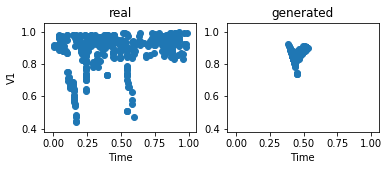

====> Epoch: 140 Average loss: 18.5607
====> Epoch: 141 Average loss: 18.5631
====> Epoch: 142 Average loss: 18.5720
====> Epoch: 143 Average loss: 18.5617
====> Epoch: 144 Average loss: 18.5645
====> Epoch: 145 Average loss: 18.5674
====> Epoch: 146 Average loss: 18.5778
====> Epoch: 147 Average loss: 18.5581
====> Epoch: 148 Average loss: 18.5689
====> Epoch: 149 Average loss: 18.5604
394 394
epoch: 150, Accuracy: 0.9898477157360406


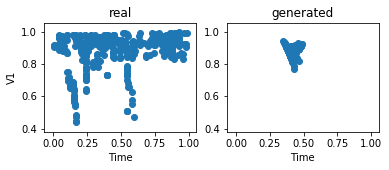

====> Epoch: 150 Average loss: 18.5439
====> Epoch: 151 Average loss: 18.5347
====> Epoch: 152 Average loss: 18.5324
====> Epoch: 153 Average loss: 18.5177
====> Epoch: 154 Average loss: 18.5161
====> Epoch: 155 Average loss: 18.5226
====> Epoch: 156 Average loss: 18.5150
====> Epoch: 157 Average loss: 18.5210
====> Epoch: 158 Average loss: 18.5230
====> Epoch: 159 Average loss: 18.5255
394 394
epoch: 160, Accuracy: 0.9898477157360406


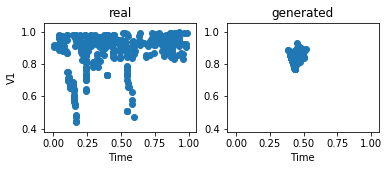

====> Epoch: 160 Average loss: 18.5331
====> Epoch: 161 Average loss: 18.5321
====> Epoch: 162 Average loss: 18.5335
====> Epoch: 163 Average loss: 18.5318
====> Epoch: 164 Average loss: 18.5201
====> Epoch: 165 Average loss: 18.5281
====> Epoch: 166 Average loss: 18.5200
====> Epoch: 167 Average loss: 18.5109
====> Epoch: 168 Average loss: 18.5089
====> Epoch: 169 Average loss: 18.5033
394 394
epoch: 170, Accuracy: 0.9847715736040609


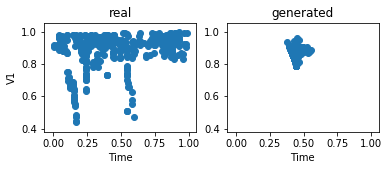

====> Epoch: 170 Average loss: 18.4947
====> Epoch: 171 Average loss: 18.4982
====> Epoch: 172 Average loss: 18.5006
====> Epoch: 173 Average loss: 18.5007
====> Epoch: 174 Average loss: 18.5192
====> Epoch: 175 Average loss: 18.5373
====> Epoch: 176 Average loss: 18.5460
====> Epoch: 177 Average loss: 18.5297
====> Epoch: 178 Average loss: 18.5238
====> Epoch: 179 Average loss: 18.5345
394 394
epoch: 180, Accuracy: 0.9898477157360406


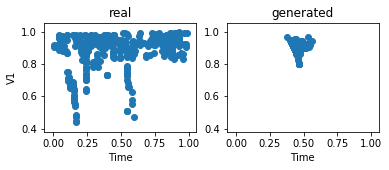

====> Epoch: 180 Average loss: 18.5248
====> Epoch: 181 Average loss: 18.5119
====> Epoch: 182 Average loss: 18.4997
====> Epoch: 183 Average loss: 18.4990
====> Epoch: 184 Average loss: 18.5021
====> Epoch: 185 Average loss: 18.5086
====> Epoch: 186 Average loss: 18.5117
====> Epoch: 187 Average loss: 18.5231
====> Epoch: 188 Average loss: 18.5254
====> Epoch: 189 Average loss: 18.5322
394 394
epoch: 190, Accuracy: 0.9898477157360406


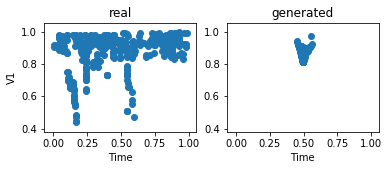

====> Epoch: 190 Average loss: 18.5432
====> Epoch: 191 Average loss: 18.5415
====> Epoch: 192 Average loss: 18.5555
====> Epoch: 193 Average loss: 18.5527
====> Epoch: 194 Average loss: 18.5608
====> Epoch: 195 Average loss: 18.5646
====> Epoch: 196 Average loss: 18.5688
====> Epoch: 197 Average loss: 18.5749
====> Epoch: 198 Average loss: 18.5747
====> Epoch: 199 Average loss: 18.5695
394 394
epoch: 200, Accuracy: 0.9796954314720813


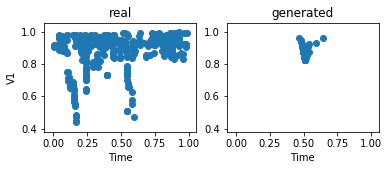

====> Epoch: 200 Average loss: 18.5798
====> Epoch: 201 Average loss: 18.5654
====> Epoch: 202 Average loss: 18.5676
====> Epoch: 203 Average loss: 18.5630
====> Epoch: 204 Average loss: 18.5652
====> Epoch: 205 Average loss: 18.5595
====> Epoch: 206 Average loss: 18.5724
====> Epoch: 207 Average loss: 18.5663
====> Epoch: 208 Average loss: 18.5641
====> Epoch: 209 Average loss: 18.5608
394 394
epoch: 210, Accuracy: 0.9847715736040609


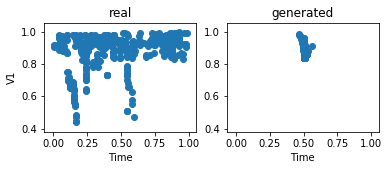

====> Epoch: 210 Average loss: 18.5693
====> Epoch: 211 Average loss: 18.5675
====> Epoch: 212 Average loss: 18.5739
====> Epoch: 213 Average loss: 18.5390
====> Epoch: 214 Average loss: 18.5392
====> Epoch: 215 Average loss: 18.5310
====> Epoch: 216 Average loss: 18.5248
====> Epoch: 217 Average loss: 18.5131
====> Epoch: 218 Average loss: 18.5091
====> Epoch: 219 Average loss: 18.5031
394 394
epoch: 220, Accuracy: 0.9898477157360406


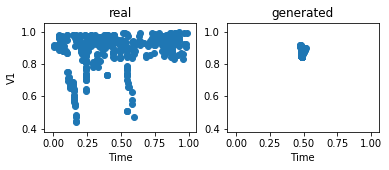

====> Epoch: 220 Average loss: 18.4981
====> Epoch: 221 Average loss: 18.5006
====> Epoch: 222 Average loss: 18.4943
====> Epoch: 223 Average loss: 18.4920
====> Epoch: 224 Average loss: 18.4959
====> Epoch: 225 Average loss: 18.4967
====> Epoch: 226 Average loss: 18.4884
====> Epoch: 227 Average loss: 18.4829
====> Epoch: 228 Average loss: 18.4870
====> Epoch: 229 Average loss: 18.4847
394 394
epoch: 230, Accuracy: 0.9873096446700508


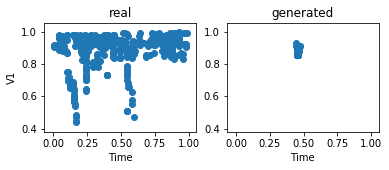

====> Epoch: 230 Average loss: 18.4738
====> Epoch: 231 Average loss: 18.4786
====> Epoch: 232 Average loss: 18.4719
====> Epoch: 233 Average loss: 18.4730
====> Epoch: 234 Average loss: 18.4715
====> Epoch: 235 Average loss: 18.4745
====> Epoch: 236 Average loss: 18.4751
====> Epoch: 237 Average loss: 18.4720
====> Epoch: 238 Average loss: 18.4737
====> Epoch: 239 Average loss: 18.4779
394 394
epoch: 240, Accuracy: 0.9873096446700508


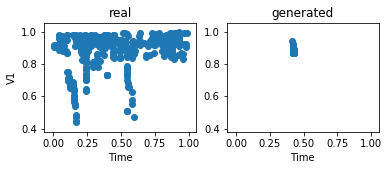

====> Epoch: 240 Average loss: 18.4797
====> Epoch: 241 Average loss: 18.4833
====> Epoch: 242 Average loss: 18.4875
====> Epoch: 243 Average loss: 18.4896
====> Epoch: 244 Average loss: 18.4950
====> Epoch: 245 Average loss: 18.4988
====> Epoch: 246 Average loss: 18.4979
====> Epoch: 247 Average loss: 18.5031
====> Epoch: 248 Average loss: 18.5036
====> Epoch: 249 Average loss: 18.5048
394 394
epoch: 250, Accuracy: 0.9898477157360406


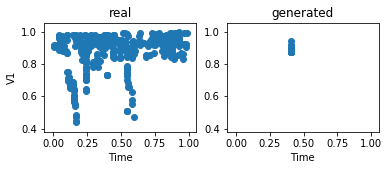

====> Epoch: 250 Average loss: 18.5041
====> Epoch: 251 Average loss: 18.5052
====> Epoch: 252 Average loss: 18.5067
====> Epoch: 253 Average loss: 18.5065
====> Epoch: 254 Average loss: 18.5045
====> Epoch: 255 Average loss: 18.5032
====> Epoch: 256 Average loss: 18.5019
====> Epoch: 257 Average loss: 18.4992
====> Epoch: 258 Average loss: 18.4968
====> Epoch: 259 Average loss: 18.4949
394 394
epoch: 260, Accuracy: 0.9949238578680203


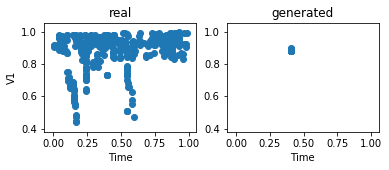

====> Epoch: 260 Average loss: 18.4923
====> Epoch: 261 Average loss: 18.4898
====> Epoch: 262 Average loss: 18.4876
====> Epoch: 263 Average loss: 18.4848
====> Epoch: 264 Average loss: 18.4826
====> Epoch: 265 Average loss: 18.4807
====> Epoch: 266 Average loss: 18.4779
====> Epoch: 267 Average loss: 18.4760
====> Epoch: 268 Average loss: 18.4749
====> Epoch: 269 Average loss: 18.4733
394 394
epoch: 270, Accuracy: 0.9974619289340102


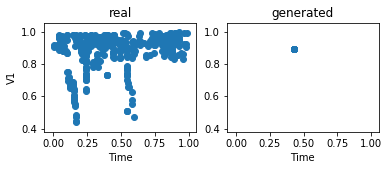

====> Epoch: 270 Average loss: 18.4720
====> Epoch: 271 Average loss: 18.4722
====> Epoch: 272 Average loss: 18.4711
====> Epoch: 273 Average loss: 18.4839
====> Epoch: 274 Average loss: 18.4718
====> Epoch: 275 Average loss: 18.4737
====> Epoch: 276 Average loss: 18.4757
====> Epoch: 277 Average loss: 18.4753
====> Epoch: 278 Average loss: 18.4778
====> Epoch: 279 Average loss: 18.4791
394 394
epoch: 280, Accuracy: 0.9974619289340102


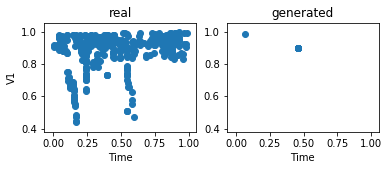

====> Epoch: 280 Average loss: 18.5086
====> Epoch: 281 Average loss: 18.4838
====> Epoch: 282 Average loss: 18.4860
====> Epoch: 283 Average loss: 18.4886
====> Epoch: 284 Average loss: 18.4908
====> Epoch: 285 Average loss: 18.4931
====> Epoch: 286 Average loss: 18.4968
====> Epoch: 287 Average loss: 18.4974
====> Epoch: 288 Average loss: 18.5006
====> Epoch: 289 Average loss: 18.5022
394 394
epoch: 290, Accuracy: 0.9949238578680203


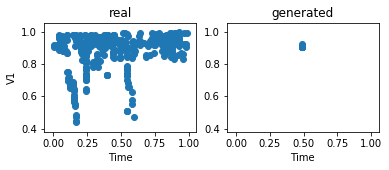

====> Epoch: 290 Average loss: 18.5024
====> Epoch: 291 Average loss: 18.5032
====> Epoch: 292 Average loss: 18.5040
====> Epoch: 293 Average loss: 18.5044
====> Epoch: 294 Average loss: 18.5045
====> Epoch: 295 Average loss: 18.5042
====> Epoch: 296 Average loss: 18.5036
====> Epoch: 297 Average loss: 18.5026
====> Epoch: 298 Average loss: 18.5014
====> Epoch: 299 Average loss: 18.4998
394 394
epoch: 300, Accuracy: 1.0


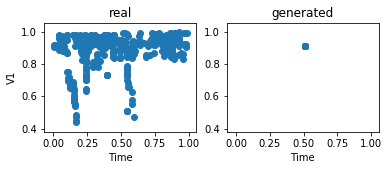

====> Epoch: 300 Average loss: 18.4979
====> Epoch: 301 Average loss: 18.4966
====> Epoch: 302 Average loss: 18.4934
====> Epoch: 303 Average loss: 18.4909
====> Epoch: 304 Average loss: 18.4882
====> Epoch: 305 Average loss: 18.4855
====> Epoch: 306 Average loss: 18.4826
====> Epoch: 307 Average loss: 18.4800
====> Epoch: 308 Average loss: 18.4786
====> Epoch: 309 Average loss: 18.4746
394 394
epoch: 310, Accuracy: 0.9974619289340102


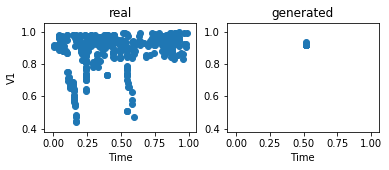

====> Epoch: 310 Average loss: 18.4720
====> Epoch: 311 Average loss: 18.4699
====> Epoch: 312 Average loss: 18.4678
====> Epoch: 313 Average loss: 18.4667
====> Epoch: 314 Average loss: 18.4645
====> Epoch: 315 Average loss: 18.4632
====> Epoch: 316 Average loss: 18.4622
====> Epoch: 317 Average loss: 18.4615
====> Epoch: 318 Average loss: 18.4612
====> Epoch: 319 Average loss: 18.4608
394 394
epoch: 320, Accuracy: 0.9898477157360406


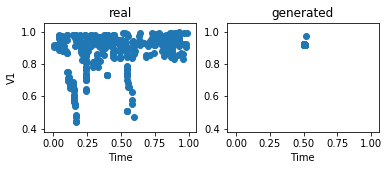

====> Epoch: 320 Average loss: 18.4620
====> Epoch: 321 Average loss: 18.4640
====> Epoch: 322 Average loss: 18.4616
====> Epoch: 323 Average loss: 18.4630
====> Epoch: 324 Average loss: 18.4650
====> Epoch: 325 Average loss: 18.4639
====> Epoch: 326 Average loss: 18.4649
====> Epoch: 327 Average loss: 18.4659
====> Epoch: 328 Average loss: 18.4672
====> Epoch: 329 Average loss: 18.4705
394 394
epoch: 330, Accuracy: 0.9898477157360406


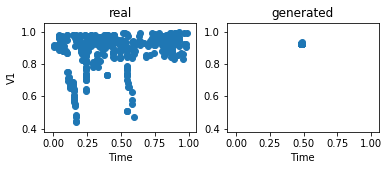

====> Epoch: 330 Average loss: 18.4696
====> Epoch: 331 Average loss: 18.4714
====> Epoch: 332 Average loss: 18.4739
====> Epoch: 333 Average loss: 18.4739
====> Epoch: 334 Average loss: 18.4743
====> Epoch: 335 Average loss: 18.4766
====> Epoch: 336 Average loss: 18.4763
====> Epoch: 337 Average loss: 18.4778
====> Epoch: 338 Average loss: 18.4793
====> Epoch: 339 Average loss: 18.4790
394 394
epoch: 340, Accuracy: 0.9923857868020305


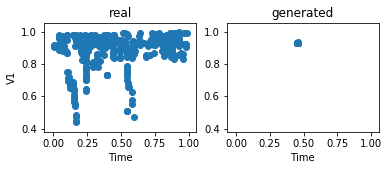

====> Epoch: 340 Average loss: 18.4791
====> Epoch: 341 Average loss: 18.4812
====> Epoch: 342 Average loss: 18.4799
====> Epoch: 343 Average loss: 18.4803
====> Epoch: 344 Average loss: 18.4825
====> Epoch: 345 Average loss: 18.4805
====> Epoch: 346 Average loss: 18.4815
====> Epoch: 347 Average loss: 18.4809
====> Epoch: 348 Average loss: 18.4829
====> Epoch: 349 Average loss: 18.4811
394 394
epoch: 350, Accuracy: 0.9898477157360406


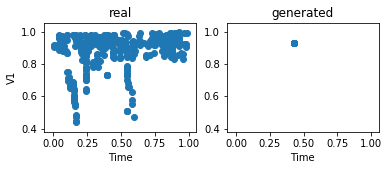

====> Epoch: 350 Average loss: 18.4812
====> Epoch: 351 Average loss: 18.4813
====> Epoch: 352 Average loss: 18.4815
====> Epoch: 353 Average loss: 18.4817
====> Epoch: 354 Average loss: 18.4820
====> Epoch: 355 Average loss: 18.4824
====> Epoch: 356 Average loss: 18.4829
====> Epoch: 357 Average loss: 18.4835
====> Epoch: 358 Average loss: 18.4845
====> Epoch: 359 Average loss: 18.4849
394 394
epoch: 360, Accuracy: 0.9898477157360406


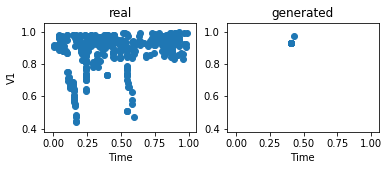

====> Epoch: 360 Average loss: 18.4879
====> Epoch: 361 Average loss: 18.4870
====> Epoch: 362 Average loss: 18.4883
====> Epoch: 363 Average loss: 18.4896
====> Epoch: 364 Average loss: 18.4910
====> Epoch: 365 Average loss: 18.4925
====> Epoch: 366 Average loss: 18.4940
====> Epoch: 367 Average loss: 18.4956
====> Epoch: 368 Average loss: 18.4972
====> Epoch: 369 Average loss: 18.4988
394 394
epoch: 370, Accuracy: 0.8071065989847716


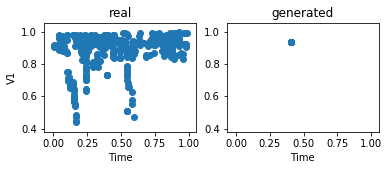

====> Epoch: 370 Average loss: 18.5003
====> Epoch: 371 Average loss: 18.5017
====> Epoch: 372 Average loss: 18.5029
====> Epoch: 373 Average loss: 18.5053
====> Epoch: 374 Average loss: 18.5050
====> Epoch: 375 Average loss: 18.5057
====> Epoch: 376 Average loss: 18.5061
====> Epoch: 377 Average loss: 18.5063
====> Epoch: 378 Average loss: 18.5062
====> Epoch: 379 Average loss: 18.5057
394 394
epoch: 380, Accuracy: 0.9670050761421319


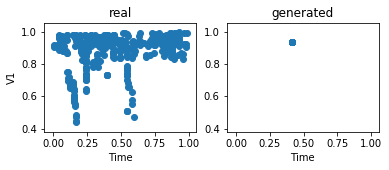

====> Epoch: 380 Average loss: 18.5049
====> Epoch: 381 Average loss: 18.5038
====> Epoch: 382 Average loss: 18.5023
====> Epoch: 383 Average loss: 18.5005
====> Epoch: 384 Average loss: 18.4983
====> Epoch: 385 Average loss: 18.4959
====> Epoch: 386 Average loss: 18.4931
====> Epoch: 387 Average loss: 18.4901
====> Epoch: 388 Average loss: 18.4868
====> Epoch: 389 Average loss: 18.4834
394 394
epoch: 390, Accuracy: 0.9949238578680203


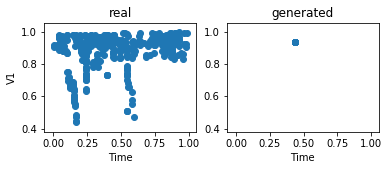

====> Epoch: 390 Average loss: 18.4798
====> Epoch: 391 Average loss: 18.4760
====> Epoch: 392 Average loss: 18.4722
====> Epoch: 393 Average loss: 18.4684
====> Epoch: 394 Average loss: 18.4645
====> Epoch: 395 Average loss: 18.4607
====> Epoch: 396 Average loss: 18.4569
====> Epoch: 397 Average loss: 18.4533
====> Epoch: 398 Average loss: 18.4499
====> Epoch: 399 Average loss: 18.4466
394 394
epoch: 400, Accuracy: 1.0


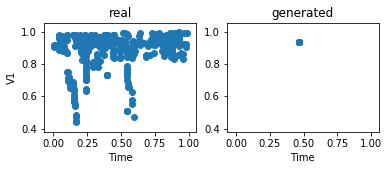

====> Epoch: 400 Average loss: 18.4436
====> Epoch: 401 Average loss: 18.4409
====> Epoch: 402 Average loss: 18.4384
====> Epoch: 403 Average loss: 18.4362
====> Epoch: 404 Average loss: 18.4344
====> Epoch: 405 Average loss: 18.4330
====> Epoch: 406 Average loss: 18.4319
====> Epoch: 407 Average loss: 18.4350
====> Epoch: 408 Average loss: 18.4310
====> Epoch: 409 Average loss: 18.4312
394 394
epoch: 410, Accuracy: 1.0


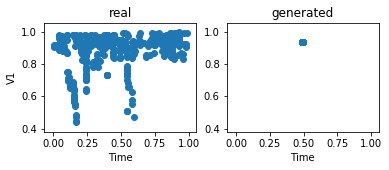

====> Epoch: 410 Average loss: 18.4318
====> Epoch: 411 Average loss: 18.4328
====> Epoch: 412 Average loss: 18.4343
====> Epoch: 413 Average loss: 18.4361
====> Epoch: 414 Average loss: 18.4385
====> Epoch: 415 Average loss: 18.4412
====> Epoch: 416 Average loss: 18.4443
====> Epoch: 417 Average loss: 18.4478
====> Epoch: 418 Average loss: 18.4516
====> Epoch: 419 Average loss: 18.4557
394 394
epoch: 420, Accuracy: 1.0


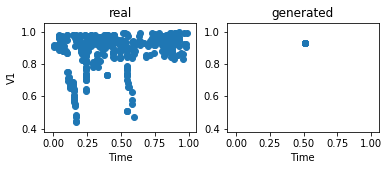

====> Epoch: 420 Average loss: 18.4601
====> Epoch: 421 Average loss: 18.4647
====> Epoch: 422 Average loss: 18.4694
====> Epoch: 423 Average loss: 18.4752
====> Epoch: 424 Average loss: 18.4793
====> Epoch: 425 Average loss: 18.4842
====> Epoch: 426 Average loss: 18.4892
====> Epoch: 427 Average loss: 18.4940
====> Epoch: 428 Average loss: 18.4987
====> Epoch: 429 Average loss: 18.5032
394 394
epoch: 430, Accuracy: 0.8096446700507615


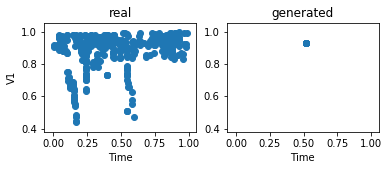

====> Epoch: 430 Average loss: 18.5075
====> Epoch: 431 Average loss: 18.5115
====> Epoch: 432 Average loss: 18.5152
====> Epoch: 433 Average loss: 18.5185
====> Epoch: 434 Average loss: 18.5215
====> Epoch: 435 Average loss: 18.5241
====> Epoch: 436 Average loss: 18.5263
====> Epoch: 437 Average loss: 18.5280
====> Epoch: 438 Average loss: 18.5293
====> Epoch: 439 Average loss: 18.5301
394 394
epoch: 440, Accuracy: 0.9949238578680203


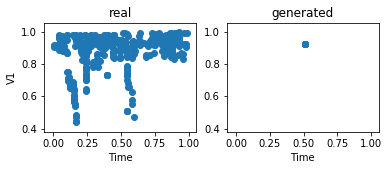

====> Epoch: 440 Average loss: 18.5305
====> Epoch: 441 Average loss: 18.5304
====> Epoch: 442 Average loss: 18.5298
====> Epoch: 443 Average loss: 18.5289
====> Epoch: 444 Average loss: 18.5275
====> Epoch: 445 Average loss: 18.5257
====> Epoch: 446 Average loss: 18.5235
====> Epoch: 447 Average loss: 18.5209
====> Epoch: 448 Average loss: 18.5180
====> Epoch: 449 Average loss: 18.5147
394 394
epoch: 450, Accuracy: 0.9974619289340102


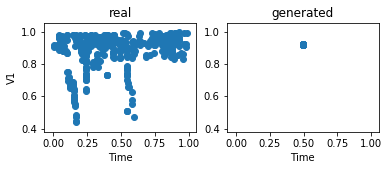

====> Epoch: 450 Average loss: 18.5112
====> Epoch: 451 Average loss: 18.5074
====> Epoch: 452 Average loss: 18.5034
====> Epoch: 453 Average loss: 18.4992
====> Epoch: 454 Average loss: 18.4949
====> Epoch: 455 Average loss: 18.4905
====> Epoch: 456 Average loss: 18.4859
====> Epoch: 457 Average loss: 18.4814
====> Epoch: 458 Average loss: 18.4769
====> Epoch: 459 Average loss: 18.4724
394 394
epoch: 460, Accuracy: 0.9898477157360406


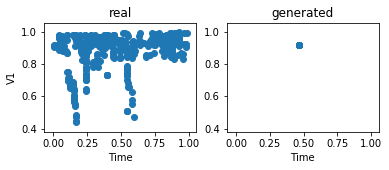

====> Epoch: 460 Average loss: 18.4680
====> Epoch: 461 Average loss: 18.4638
====> Epoch: 462 Average loss: 18.4597
====> Epoch: 463 Average loss: 18.4559
====> Epoch: 464 Average loss: 18.4523
====> Epoch: 465 Average loss: 18.4491
====> Epoch: 466 Average loss: 18.4461
====> Epoch: 467 Average loss: 18.4435
====> Epoch: 468 Average loss: 18.4413
====> Epoch: 469 Average loss: 18.4395
394 394
epoch: 470, Accuracy: 0.9949238578680203


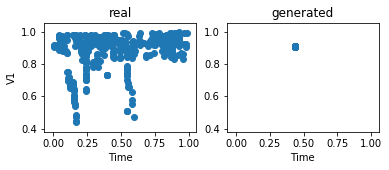

====> Epoch: 470 Average loss: 18.4381
====> Epoch: 471 Average loss: 18.4421
====> Epoch: 472 Average loss: 18.4367
====> Epoch: 473 Average loss: 18.4366
====> Epoch: 474 Average loss: 18.4370
====> Epoch: 475 Average loss: 18.4377
====> Epoch: 476 Average loss: 18.4389
====> Epoch: 477 Average loss: 18.4404
====> Epoch: 478 Average loss: 18.4487
====> Epoch: 479 Average loss: 18.4445
394 394
epoch: 480, Accuracy: 0.9974619289340102


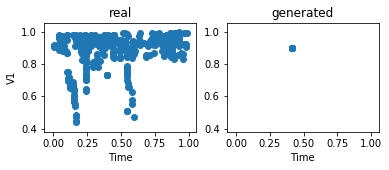

====> Epoch: 480 Average loss: 18.4470
====> Epoch: 481 Average loss: 18.4498
====> Epoch: 482 Average loss: 18.4527
====> Epoch: 483 Average loss: 18.4558
====> Epoch: 484 Average loss: 18.4591
====> Epoch: 485 Average loss: 18.4624
====> Epoch: 486 Average loss: 18.4657
====> Epoch: 487 Average loss: 18.4690
====> Epoch: 488 Average loss: 18.4722
====> Epoch: 489 Average loss: 18.4754
394 394
epoch: 490, Accuracy: 0.9949238578680203


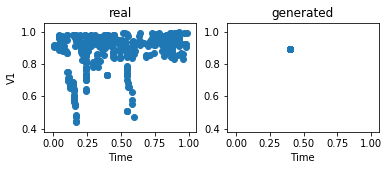

====> Epoch: 490 Average loss: 18.4784
====> Epoch: 491 Average loss: 18.4813
====> Epoch: 492 Average loss: 18.4841
====> Epoch: 493 Average loss: 18.4866
====> Epoch: 494 Average loss: 18.4889
====> Epoch: 495 Average loss: 18.4910
====> Epoch: 496 Average loss: 18.4929
====> Epoch: 497 Average loss: 18.4945
====> Epoch: 498 Average loss: 18.4959
====> Epoch: 499 Average loss: 18.4970
It took  25.758174896240234


In [13]:
losses = TESTVAE.trainVAE(dataloader, num_epochs=500, data_dim = dataloader.dataset.features.size(1),feature_cols=feature_cols, embeddingDim=5, compressDims=(25, 15), decompressDims=(15, 25))

In [14]:
# losses = vae.trainVAE(dataloader, num_epochs=5, data_dim = dataloader.dataset.features.size(1),feature_cols=feature_cols)#, embeddingDim=128, compressDims=(128, 128), decompressDims=(128, 128))

In [15]:
# xgblosses

In [16]:
number = 0.68020305

In [17]:
#

In [18]:
losses

[8354.349838256836,
 8279.287002563477,
 8215.256561279297,
 8151.209518432617,
 8078.957305908203,
 8010.034072875977,
 7926.39289855957,
 7845.583145141602,
 7764.647674560547,
 7696.697250366211,
 7649.961456298828,
 7605.908767700195,
 7554.063751220703,
 7548.161346435547,
 7535.2900390625,
 7482.490188598633,
 7474.589950561523,
 7447.66276550293,
 7428.567108154297,
 7420.174331665039,
 7428.41145324707,
 7434.951416015625,
 7432.5479736328125,
 7434.9259033203125,
 7442.783111572266,
 7446.586410522461,
 7452.884140014648,
 7452.994827270508,
 7452.106781005859,
 7453.920623779297,
 7450.595672607422,
 7450.641952514648,
 7436.808929443359,
 7427.940872192383,
 7420.26188659668,
 7416.636581420898,
 7409.980926513672,
 7403.490127563477,
 7406.401382446289,
 7399.272903442383,
 7400.356857299805,
 7395.362487792969,
 7388.546844482422,
 7385.273788452148,
 7378.734176635742,
 7374.87744140625,
 7356.076889038086,
 7349.313293457031,
 7343.185501098633,
 7337.408050537109,
 7330

In [19]:
generatedData = TESTVAE.generate(n=17500, num_epochs=2500, epoch=150,data_dim=30,embeddingDim=5, compressDims=(25, 15), batch_size=64)

In [20]:
generatedData

[array([0.38859528, 0.69501793, 0.6473698 , 0.6545951 , 0.431826  ,
        0.66914034, 0.25995126, 0.18061267, 0.6881107 , 0.4022145 ,
        0.4277085 , 0.42355397, 0.36124712, 0.4139    , 0.34642088,
        0.29460418, 0.30392888, 0.46999162, 0.50089014, 0.53405327,
        0.55567276, 0.5053298 , 0.51155955, 0.5970035 , 0.35739094,
        0.51443577, 0.34763983, 0.2072489 , 0.26565868, 0.1056755 ],
       dtype=float32),
 array([0.43893608, 0.72020805, 0.67129976, 0.66389984, 0.4451645 ,
        0.6498225 , 0.21241625, 0.20709255, 0.67822564, 0.3382249 ,
        0.44274423, 0.44384187, 0.35692006, 0.42986256, 0.35525408,
        0.29307652, 0.28479558, 0.43928832, 0.50362587, 0.499989  ,
        0.57655334, 0.48933148, 0.48793566, 0.6062382 , 0.3243228 ,
        0.52092814, 0.32946914, 0.22622302, 0.31106502, 0.05102512],
       dtype=float32),
 array([0.377228  , 0.71200824, 0.6590154 , 0.6719678 , 0.44106993,
        0.67823094, 0.23474528, 0.15459396, 0.7042636 , 0.39206043,


In [21]:
227845/100

2278.45

In [22]:
train.shape

(227845, 31)

In [23]:
more_data = generatedData

In [24]:
more_data = pd.DataFrame(more_data[:])

In [25]:
len(more_data)

160000

In [26]:
more_data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.388595,0.695018,0.647370,0.654595,0.431826,0.669140,0.259951,0.180613,0.688111,0.402214,...,0.555673,0.505330,0.511560,0.597004,0.357391,0.514436,0.347640,0.207249,0.265659,0.105675
1,0.438936,0.720208,0.671300,0.663900,0.445165,0.649822,0.212416,0.207093,0.678226,0.338225,...,0.576553,0.489331,0.487936,0.606238,0.324323,0.520928,0.329469,0.226223,0.311065,0.051025
2,0.377228,0.712008,0.659015,0.671968,0.441070,0.678231,0.234745,0.154594,0.704264,0.392060,...,0.540499,0.484076,0.504678,0.588675,0.366728,0.519839,0.330247,0.188650,0.268357,0.075031
3,0.428970,0.715576,0.665679,0.661130,0.447193,0.652661,0.223176,0.203389,0.679452,0.347461,...,0.573757,0.488774,0.493789,0.605785,0.326568,0.520721,0.335455,0.221855,0.305567,0.059655
4,0.374443,0.700661,0.650735,0.663505,0.430810,0.677570,0.252756,0.161410,0.699003,0.409867,...,0.543013,0.499704,0.510805,0.589898,0.371243,0.515398,0.339360,0.194733,0.257268,0.098324


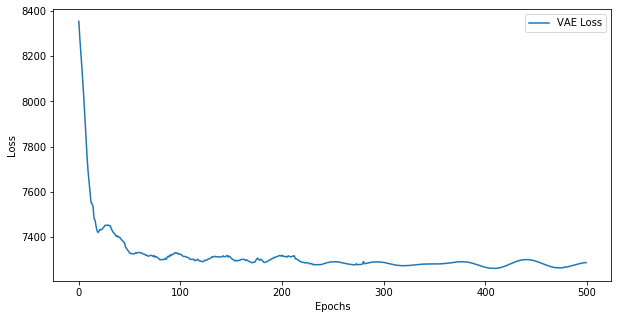

In [27]:
# print(min(xgblosses))
plt.figure(figsize=(10,5))
# plt.title(f"VAE Loss During Training")
plt.plot(losses,label="VAE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/vae/VAE.png')
plt.show()

# w = 10
# a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
# plt.title(f"VAE - XGB Accuracy During Training")
# plt.plot(a)
# plt.savefig(f'reports/figures/vae/xgblosses_VAE.png')
# plt.show()

In [28]:
amount=train.shape[0]
device='cpu'

In [29]:
train.shape[0]

227845

In [30]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [31]:
b.shape

(160000, 31)

In [32]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.388595,0.695018,0.647370,0.654595,0.431826,0.669140,0.259951,0.180613,0.688111,0.402214,...,0.505330,0.511560,0.597004,0.357391,0.514436,0.347640,0.207249,0.265659,0.105675,1.0
1,0.438936,0.720208,0.671300,0.663900,0.445165,0.649822,0.212416,0.207093,0.678226,0.338225,...,0.489331,0.487936,0.606238,0.324323,0.520928,0.329469,0.226223,0.311065,0.051025,1.0
2,0.377228,0.712008,0.659015,0.671968,0.441070,0.678231,0.234745,0.154594,0.704264,0.392060,...,0.484076,0.504678,0.588675,0.366728,0.519839,0.330247,0.188650,0.268357,0.075031,1.0
3,0.428970,0.715576,0.665679,0.661130,0.447193,0.652661,0.223176,0.203389,0.679452,0.347461,...,0.488774,0.493789,0.605785,0.326568,0.520721,0.335455,0.221855,0.305567,0.059655,1.0
4,0.374443,0.700661,0.650735,0.663505,0.430810,0.677570,0.252756,0.161410,0.699003,0.409867,...,0.499704,0.510805,0.589898,0.371243,0.515398,0.339360,0.194733,0.257268,0.098324,1.0


In [33]:
train.shape

(227845, 31)

In [34]:
type(train)

pandas.core.frame.DataFrame

In [35]:
a = np.array(generatedData)

In [36]:
a.size

4800000

In [37]:
train = train.append(df_generatedData)

In [38]:
train_y = train.Class

In [39]:
train_y.isnull().sum()

0

In [40]:
train_X = train
train_X.drop('Class', axis=1, inplace=True)

# XGBoost

In [41]:
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [42]:
train_y.shape

(387845,)

In [43]:
train_y.head()

223361    0.0
165061    0.0
238186    0.0
150562    0.0
138452    0.0
Name: Class, dtype: float64

In [44]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  33.224934816360474


In [45]:
preds = preds.round()

In [46]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.903026
Recall Score: 0.806122
Precision Score: 0.951807
F1 Score: 0.872928
Accuracy Score: 0.999596
---------------------------------------------------------------------------------------------------------------------------------------
